## Lasagne implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
# os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/bin,KERAS_BACKEND=theano '
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/bin'

# os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run'
# os.environ['THEANO_FLAGS']='device=cuda'


channel_first = True
channel_axis=1
# import pygpu
# print pygpu.__version__

In [2]:
import numpy as np
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import DropoutLayer, ReshapeLayer, InputLayer 
floatX = theano.config.floatX
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, ConcatLayer, NonlinearityLayer
from lasagne.layers import batch_norm
from lasagne.nonlinearities import LeakyRectify, sigmoid, rectify, tanh

Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 970 (0000:01:00.0)


In [3]:
conv_init = lasagne.init.Normal(0.02, 0)
gamma_init = lasagne.init.Normal(0.02, 1)

In [4]:
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    l=-1
    def conv2d(x, nf, l, stride=2, nonlinearity=LeakyRectify(0.2)):
#         nonlocal l
        l+=1
        return l,Conv2DLayer(x, num_filters=nf, filter_size=4, stride=stride, 
                           pad=1, W=conv_init, flip_filters=False,
                            nonlinearity=nonlinearity,
                           name="conv2d_{}".format(l)
                          )
    _ = InputLayer(shape=(None, nc_in, None, None), name="input")
    l, _ = conv2d(_, ndf, l)
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        l,_ = conv2d(_, out_feat, l)
        _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)
    out_feat = ndf*min(2**max_layers, 8)
    l,_ = conv2d(_, out_feat, l, stride=1)
    _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)         
    l,_ = conv2d(_, 1, l, stride=1, nonlinearity=sigmoid if use_sigmoid else None)
    return _


In [5]:
# from https://gist.github.com/ajbrock/a3858c26282d9731191901b397b3ce9f
def reflect_pad(x, width, batch_ndim=1):
    """
    Pad a tensor with a constant value.
    Parameters
    ----------
    x : tensor
    width : int, iterable of int, or iterable of tuple
        Padding width. If an int, pads each axis symmetrically with the same
        amount in the beginning and end. If an iterable of int, defines the
        symmetric padding width separately for each axis. If an iterable of
        tuples of two ints, defines a seperate padding width for each beginning
        and end of each axis.
    batch_ndim : integer
        Dimensions before the value will not be padded.
    """
    
    # Idea for how to make this happen: Flip the tensor horizontally to grab horizontal values, then vertically to grab vertical values
    # alternatively, just slice correctly
    input_shape = x.shape
    input_ndim = x.ndim

    output_shape = list(input_shape)
    indices = [slice(None) for _ in output_shape]

    if isinstance(width, int):
        widths = [width] * (input_ndim - batch_ndim)
    else:
        widths = width

    for k, w in enumerate(widths):
        try:
            l, r = w
        except TypeError:
            l = r = w
        output_shape[k + batch_ndim] += l + r
        indices[k + batch_ndim] = slice(l, l + input_shape[k + batch_ndim])

    # Create output array
    out = T.zeros(output_shape)
    
    # Vertical Reflections
    out=T.set_subtensor(out[:,:,:width,width:-width], x[:,:,width:0:-1,:])# out[:,:,:width,width:-width] = x[:,:,width:0:-1,:]
    out=T.set_subtensor(out[:,:,-width:,width:-width], x[:,:,-2:-(2+width):-1,:])#out[:,:,-width:,width:-width] = x[:,:,-2:-(2+width):-1,:]
    
    # Place X in out
    # out = T.set_subtensor(out[tuple(indices)], x) # or, alternative, out[width:-width,width:-width] = x
    out=T.set_subtensor(out[:,:,width:-width,width:-width],x)#out[:,:,width:-width,width:-width] = x
   
   #Horizontal reflections
    out=T.set_subtensor(out[:,:,:,:width],out[:,:,:,(2*width):width:-1])#out[:,:,:,:width] = out[:,:,:,(2*width):width:-1]
    out=T.set_subtensor(out[:,:,:,-width:],out[:,:,:,-(width+2):-(2*width+2):-1])#out[:,:,:,-width:] = out[:,:,:,-(width+2):-(2*width+2):-1]
    
    
    return out
    
class ReflectLayer(lasagne.layers.Layer):

    def __init__(self, incoming, width, batch_ndim=2, **kwargs):
        super(ReflectLayer, self).__init__(incoming, **kwargs)
        self.width = width
        self.batch_ndim = batch_ndim

    def get_output_shape_for(self, input_shape):
        output_shape = list(input_shape)

        if isinstance(self.width, int):
            widths = [self.width] * (len(input_shape) - self.batch_ndim)
        else:
            widths = self.width

        for k, w in enumerate(widths):
            if output_shape[k + self.batch_ndim] is None:
                continue
            else:
                try:
                    l, r = w
                except TypeError:
                    l = r = w
                output_shape[k + self.batch_ndim] += l + r
        return tuple(output_shape)

    def get_output_for(self, input, **kwargs):
        return reflect_pad(input, self.width, self.batch_ndim) 

In [6]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
            
        x = Conv2DLayer(x, num_filters=nf_next, filter_size=4, stride=2, pad=1, W=conv_init, flip_filters=False,                
                nonlinearity=None, name='conv2d_{}'.format(s))
        if s>2:
            if use_batchnorm:
                x = batch_norm(x, epsilon=1e-5, gamma=gamma_init)
            x2 = NonlinearityLayer(x, nonlinearity=LeakyRectify(0.2), name="leakyRelu_{}".format(s))
            x2 = block(x2, s//2, nf_next)
            x = ConcatLayer([x, x2], name="concat_{}".format(s))            
        x = NonlinearityLayer(x, nonlinearity=rectify, name="Relu_{}".format(s))
        x = TransposedConv2DLayer(x, num_filters=nf_out, filter_size=4, stride=2, crop=1, W=conv_init, 
                                  flip_filters=True, nonlinearity=None, name="convt_{}".format(s))
        if use_batchnorm:
            x = batch_norm(x, epsilon=1e-5, gamma=gamma_init)
        if s <= 8:
            x = DropoutLayer(x, 0.5, name="dropout_{}".format(s))
        return x
    
    s = isize if fixed_input_size else None
    _ = InputLayer(shape=(None, nc_in, s, s), name='input')
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = NonlinearityLayer(_, nonlinearity=tanh, name='tanh')
    return _

In [7]:
from lasagne.layers import ElemwiseSumLayer, SliceLayer
def reflect_padding_conv(_, num_filters, filter_size=3, stride=1, nonlinearity=rectify, use_batchnorm=True, **k):
    assert filter_size%2==1
    pad_size = filter_size>>1
    _ = ReflectLayer(_, width=pad_size)
    _ = Conv2DLayer(_, num_filters=num_filters, filter_size=filter_size, stride=stride, 
                           pad=0, W=conv_init, flip_filters=False, nonlinearity=nonlinearity, **k)
    if use_batchnorm:
        _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)
    return _
def res_block(_, num_filters, name):
    x = _
    _ = reflect_padding_conv(_, num_filters, name=name+"_conv1")
    _ = reflect_padding_conv(_, num_filters, nonlinearity=None, name=name+"_conv2")
    return ElemwiseSumLayer([x, _], name=name+"_add")

def RESNET_G(nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):
    s = None
    _ = InputLayer(shape=(None, nc_in, s, s), name='input')    
    _ = reflect_padding_conv(_, ngf, 7, name="first")    
    for m in [2,4]:
        _ = Conv2DLayer(_, num_filters=ngf*m, filter_size=4, stride=2, 
                           pad=1, W=conv_init, flip_filters=False, 
                           nonlinearity=rectify, name='conv_{}'.format(ngf*m))
        _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)
    for i in range(6):
        _ = res_block(_, ngf*4, "res_block{}".format(i))
    for m in [2,1]:
        _ = TransposedConv2DLayer(_, num_filters=ngf*m, filter_size=3, stride=2, 
                            crop=0, W=conv_init, flip_filters=True,
                            nonlinearity=rectify, name="convt_{}".format(ngf*m))
        _ = batch_norm(_, epsilon=1e-5, gamma=gamma_init)
        _ = SliceLayer(_, slice(0, -1),2)
        _ = SliceLayer(_, slice(0, -1),3)    
    _ = reflect_padding_conv(_, nc_out, 7, nonlinearity=tanh, use_batchnorm=False, name="output")
    return _

In [8]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
#λ = 10 if use_lsgan else 100
lambda_ = 10

# loadSize = 143
# loadSize = 286
# imageSize = 256
loadSize = 143
imageSize = 128

# imageSizeX, imageSizeY = 128, 192
batchSize = 1
lrD = 5e-5
lrG = 5e-5

In [9]:
netDA = BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, max_layers=3, use_sigmoid = not use_lsgan)
# for l in lasagne.layers.get_all_layers(netDA):
#     print(l.name,  l.output_shape)


In [10]:
#netG = UNET_G(imageSize, nc_in, nc_out, ngf)
netGB = RESNET_G(nc_in, nc_out, ngf)
netGA = RESNET_G(nc_out, nc_in, ngf)
# netGA.summary()
# for l in lasagne.layers.get_all_layers(netGA):
#     print(l.name,  l.output_shape)

In [11]:
from lasagne.layers import get_output, get_all_layers,get_all_params
no_bn_avg = dict( batch_norm_update_averages=False, batch_norm_use_averages=False)

if use_lsgan:
    loss_fn = lambda output, target : T.mean( (output-target)**2 )
else:
    loss_fn = lambda output, target : -T.mean(T.log(output+1e-12)*target+T.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = get_all_layers(netG1)[0].input_var    
    fake_output = get_output(netG1, **no_bn_avg)
    rec_input = get_output(netG2, inputs=fake_output)
    fn_generate = theano.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [12]:
def D_loss(netD, real, fake, rec):
    output_real = get_output(netD, inputs=real, **no_bn_avg)
    output_fake = get_output(netD, inputs=fake, **no_bn_avg)
    loss_D_real = loss_fn(output_real, T.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, T.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, T.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = T.mean(abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [13]:
# from keras.optimizers import RMSprop, SGD, Adam

params_netD = get_all_params([netDA, netDB], trainable=True)
params_netG = get_all_params([netGA, netGB], trainable=True)

loss_G = loss_GA+loss_GB+lambda_*loss_cyc
loss_D = loss_DA+loss_DB


# netD_opt = Adam(lr=lrD, beta_1=0.5)
# training_updates = netD_opt.get_updates(params_netD,[],loss_D)
# netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], updates=training_updates)

# netG_opt = Adam(lr=lrG, beta_1=0.5)
# training_updates = netG_opt.get_updates(params_netG,[], loss_G)
# netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], updates=training_updates)

optimize_D = lasagne.updates.adam(loss_D, params_netD, learning_rate=lrD, beta1=0.5)
netD_train = theano.function([real_A, real_B], [loss_DA/2, loss_DB/2], updates=optimize_D)

optimize_G = lasagne.updates.adam(loss_G, params_netG, learning_rate=lrG, beta1=0.5)
netG_train =  theano.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], updates=optimize_G)

clamp_lower, clamp_upper = -0.02, 0.02
mn =lambda w: 1 if w.name.endswith('gamma') else 0
clamp_D_fn = theano.function([], [], updates = [(w, T.clip(w, mn(w)+clamp_lower, mn(w)+clamp_upper)) for w in params_netD])
# clamp_D_fn = K.function([], [], updates = [(w, T.clip(w, mn(w)+clamp_lower, mn(w)+clamp_upper)) for w in params_netD])



In [14]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
#     load image with BILINEAR resizing, and crop the central region. 143*143 -> 128*128
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
#     normalize,[0,255] -> [-1,1]
    arr = np.array(im)/255. * 2 -1
#     print 'im',im
#     print arr
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
#     horizontal flip
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"

# dataset = "horse2zebra"
# dataset = "face2emoji"
# dataset = 'face2president'
# dataset = "president2coach"
# dataset = 'annie2coach'
# from_style = 'hao'
from_style = 'hao'

to_style = 'president'
# to_style = 'coach'
dataset = "%s2%s" % (from_style, to_style)

# dataset = "hao2lin"
train_A = load_data('CycleGAN/{}/trainA/*.jpg'.format(from_style))
train_B = load_data('CycleGAN/{}/trainB/*.jpg'.format(to_style))
test_A = load_data('CycleGAN/{}/testA/*.jpg'.format(from_style))
test_B = load_data('CycleGAN/{}/testB/*.jpg'.format(to_style))
assert len(train_A) and len(train_B)

In [15]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

(6, 3, 128, 128)


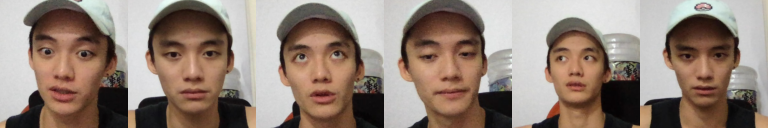

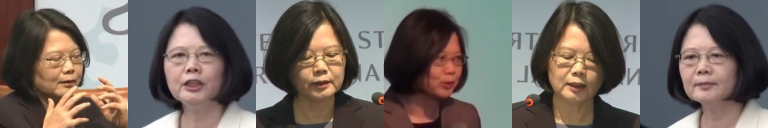

In [16]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
#     
#     im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    display(Image.fromarray(int_X))
    return int_X

# 
train_batch = minibatchAB(train_A, train_B, 6)
_, A, B = next(train_batch)
print A.shape
# print A
showX(A)
showX(B)
del train_batch, A, B





In [17]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate(X[i:i+1]) for i in range(X.shape[0])]).swapaxes(0,1)[:,:,0]
        return r
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    return showX(arr, 3)

    

In [18]:
from os.path import join
import numpy as np
import os

def save_model_tmp(path):
    v = lasagne.layers.get_all_param_values([netDA, netDB, netGA, netGB])
    np.savez('./tmp.npz', *v)
    np.savez(path, *v)
    
    
    
    
    

def save(dataset_name):
    # save models
    
    dir_path = join('./','models',dataset_name)
    if not os.path.isdir(join('./','models')):
        os.mkdir(join('./','models'))
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
        

    save_model_tmp(join(dir_path,'%s.npz' % dataset_name))
    
    

# def load(dataset_name, with_opt):
#     # load model
    
#     print 'load model from %s, with optimizer weights : %s' % (dataset_name, with_opt)
    
#     dir_path = join('./','models',dataset_name)
    
#     netDA.load_weights(join(dir_path,'netDA.hdf5'))
#     netDB.load_weights(join(dir_path,'netDB.hdf5'))
#     netGA.load_weights(join(dir_path,'netGA.hdf5'))
#     netGB.load_weights(join(dir_path,'netGB.hdf5'))
# #     netDA = load_model(join(dir_path,'netDA.hdf5'))
# #     netDB = load_model(join(dir_path,'netDB.hdf5'))
# #     netGA = load_model(join(dir_path,'netGA.hdf5'))
# #     netGB = load_model(join(dir_path,'netGB.hdf5'))
#     if with_opt:
#         training_optimizers = [netD_opt, netG_opt]
#         load_optimizers(training_optimizers, dataset_name)
    





('[260/15000][368000] Loss_D: 0.070787 0.110263 Loss_G: 0.881241 0.714859 loss_cyc 0.067979', 138872.71797513962)


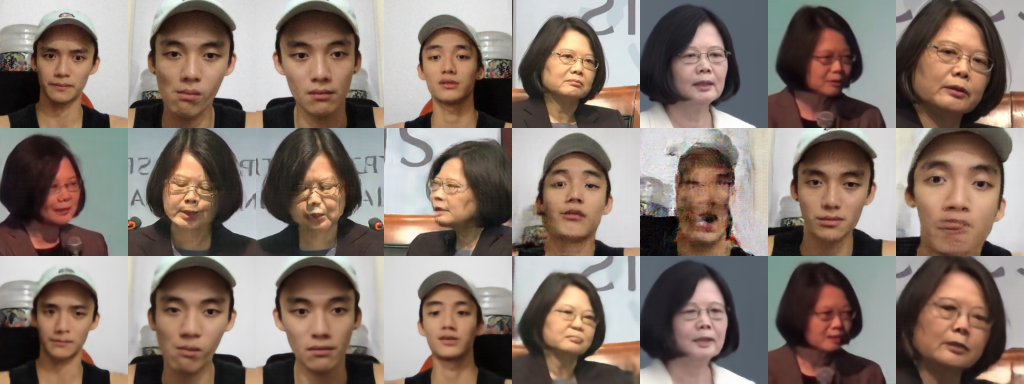

In [ ]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 15000
img_dir = join('.','buf_data','imgs')
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 40
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < niter:
    epoch, A, B = next(train_batch)        
    #clamp_D_fn()
    errDA, errDB  = netD_train(A, B)
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train(A, B)
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        test_sample = showG(A,B)      
#         print test_sample.shape
        img = Image.fromarray(test_sample)
        img.save(join(img_dir,'test_%d.jpg' % gen_iterations))
        save(dataset)
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
    if gen_iterations%10000==0:
        save(dataset+str(gen_iterations))
    

In [38]:
v = lasagne.layers.get_all_param_values([netDA, netDB, netGA, netGB])


In [39]:
np.savez('model_cycle_fber2.npz', *v)

In [40]:
del v

In [48]:
img[None].shape

(1, 3, 192, 128)

In [55]:
def saveX(fn, X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSizeY,imageSizeX), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSizeY,imageSizeX, 3)
    int_X = int_X.reshape(rows, -1, imageSizeY, imageSizeX,3).swapaxes(1,2).reshape(rows*imageSizeY,-1, 3)    
    Image.fromarray(int_X).save(fn)

In [69]:
for i in range(1,7202): #for i in range(19000,31000):
    if i%1000==0:
        print(i)
    im = Image.open('CycleGAN/inx/A_%05d.png'%i).convert('RGB')
    arr = np.array(im)
    im = Image.fromarray(arr[40:40+240//2*3,310:70:-1]).resize((128,64*3))
    img = np.float32(im)/255*2-1
    img = np.moveaxis(img, 2, 0)
    r = cycleA_generate(img[None])[0]
    im.save('CycleGAN/in/A_%05d.png'%i)
    saveX('CycleGAN/out/A_%05d.png'%i, r)


1000
2000
3000
4000
5000
6000
7000


In [66]:
for i in range(1,7202): #for i in range(19000,31000):
    if i%1000==0:
        print(i)
    im = Image.open('CycleGAN/inx/B_%05d.png'%i).convert('RGB')
    arr = np.array(im)
    im = Image.fromarray(arr[160:160+360//2*3]).resize((128,128//2*3))
    img = np.float32(im)/255*2-1
    img = np.moveaxis(img, 2, 0)
    r = cycleB_generate(img[None])[0]
    im.save('CycleGAN/in/B_%05d.png'%i)
    saveX('CycleGAN/out/B_%05d.png'%i, r)

1000
2000
3000
4000
5000
6000
7000


In [60]:
for i in range(17100,32100): #for i in range(19000,31000):
    im = Image.open('CycleGAN/A/A_%05d.png'%i).convert('RGB')
    arr = np.array(im)
    im = Image.fromarray(arr[40:40+240//2*3,310:70:-1]).resize((128,64*3))
    im.save('CycleGAN/in/A_%05d.png'%i)

In [61]:
for i in range(16000,31000): #for i in range(19000,31000):
    im = Image.open('CycleGAN/B/B_%05d.png'%i).convert('RGB')
    arr = np.array(im)
    im = Image.fromarray(arr[160:160+360//2*3]).resize((128,128//2*3))
    im.save('CycleGAN/in/B_%05d.png'%i)

In [21]:
with np.load('./models/hao2president30000/hao2president30000.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values([netDA, netDB, netGA, netGB], param_values)
print 'load done'

load done
